## 03: Hierarchal modeling

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt

from datetime import datetime
from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

### Model Pooling
Lets explore a different way of modeling the response time for my hangout conversations. My intuition would suggest that depending on the people in a hangout conversation (there can be more than one), my tendancy to reply quickly or slowly will change. As such, I could decide to model each conversation independently, estimating parameters $\mu_i$ and $\alpha_i$ for each conversation $i$.

One consideration we must make, is that some conversations have very few messages compared to others. As such, our estimates of response time for small conversations will have a higher degree of uncertinity than conversations with a large number of messages. The belo plot illustrates the discrepancy in sample size per conversation.

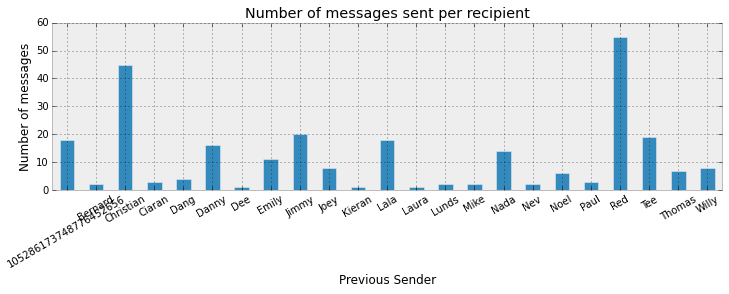

In [9]:
ax = messages.groupby('prev_sender')['conversation_id'].size().plot(
    kind='bar', figsize=(12,3), title='Number of messages sent per recipient')
_ = ax.set_xlabel('Previous Sender')
_ = ax.set_ylabel('Number of messages')
_ = plt.xticks(rotation=30)

For each message j and each conversation i, we represent the model as:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Uniform(0, 100)$$
$$\alpha_i = Uniform(0, 100)$$

In [ ]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

for p in participants:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)

        y_est = pm.NegativeBinomial('y_est', 
                                    mu=mu, 
                                    alpha=alpha, 
                                    observed=messages[my_messages['prev_sender']==p]['time_delay_seconds'].values)

        y_pred = pm.NegativeBinomial('y_pred', 
                                     mu=mu, 
                                     alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[p] = trace

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 2000
ix = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], participants[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(messages[messages['prev_sender']==p]['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], participants[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Response time (seconds)')
axs[5].set_xlabel('Response time (seconds)')

plt.tight_layout()

The above plots show the observed data (left) and the posterior predictive distribution (right) for 3 example conversations we modeled. As you can see, the posterior predictive distribution can vary considerably across conversations. This could accurately reflect the characteristics of the conversation or it could be a function of sample size.

If we combine the posterior predictive distributions across models, we would expect this to resemble the distribution of the overall dataset observed.

In [ ]:
combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.iteritems()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 20000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 20)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Partial pooling
One of the best aspects of Bayesian modeling is the flexibility of which one can create hierarchal models. Looking at the hangouts data as an example, I believe that I respond faster to some conversations and slower to others. Hence, I feel each conversation warrants its own parameter. However, it intuitively makes sense that I have an overarching tendancy to respond fast or slow to messages regardless of the conversation.

Partial modeling is a great way to model this hierarchal dependancy. I will estimate  parameters $(\mu_j)$ and $(\alpha_j)$ for each conversation j. We represent the model as:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Gamma(HyperMuMu, HyperMuDelta)$$
$$\alpha_i = Gamma(HyperAlphaMu, HyperAlphaDelta)$$
$$HyperMuMu = Uniform(0, 60)$$
$$HyperMuDelta = Uniform(0, 50)$$
$$HyperAlphaMu = Uniform(0, 10)$$
$$HyperAlphaDelta = Uniform(0, 50)$$

TODO: Comment on reparamaterization of Gamma. Currently not clear.

In [2]:
with pm.Model() as model:
    hyper_alpha_delta = pm.Uniform('hyper_alpha_delta', lower=0, upper=50)
    hyper_alpha_mu = pm.Uniform('hyper_alpha_mu', lower=0, upper=10)
    
    hyper_mu_delta = pm.Uniform('hyper_mu_delta', lower=0, upper=50)
    hyper_mu_mu = pm.Uniform('hyper_mu_mu', lower=0, upper=60)
    
    alpha = pm.Gamma('alpha', alpha=hyper_alpha_mu**2/hyper_alpha_delta**2, beta=hyper_alpha_mu/hyper_alpha_delta**2, shape=n_participants)
    mu = pm.Gamma('mu', alpha=hyper_mu_mu**2/hyper_mu_delta**2, beta=hyper_mu_mu/hyper_mu_delta**2, shape=n_participants)
    
    y_est = pm.NegativeBinomial('y_est', 
                                mu=mu[participants_idx], 
                                alpha=alpha[participants_idx], 
                                observed=messages['time_delay_seconds'].values)
    
    y_pred = pm.NegativeBinomial('y_pred', 
                                 mu=mu[participants_idx], 
                                 alpha=alpha[participants_idx],
                                 shape=messages['prev_sender'].shape)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(200000, step, progressbar=True)

NameError: name 'n_participants' is not defined

In [ ]:
_ = pm.traceplot(hierarchical_trace[100000:], 
                 vars=['mu','alpha','hyper_mu_mu',
                       'hyper_mu_delta','hyper_alpha_mu',
                       'hyper_alpha_delta'])

In [ ]:
x_lim = 60
y_pred = hierarchical_trace.get_values('y_pred').ravel()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Shrinkage effect: pooled vs hierarchal model
TODO: Comment on shrinkage effect of hierarchal model

In [ ]:
hier_mu = hierarchical_trace['mu'][500:].mean(axis=0)
hier_alpha = hierarchical_trace['alpha'][500:].mean(axis=0)
indv_mu = [indiv_traces[p]['mu'][500:].mean() for p in participants]
indv_alpha = [indiv_traces[p]['alpha'][500:].mean() for p in participants]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='mu', ylabel='alpha', 
                     title='Hierarchical vs. Non-hierarchical Negative Binomial Model', 
                     xlim=(5, 45), ylim=(-10, 60))

ax.scatter(indv_mu, indv_alpha, c=colors[5], s=50, label = 'Non Hierarchical', zorder=3)
ax.scatter(hier_mu, hier_alpha, c=colors[6], s=50, label = 'Hierarchical', zorder=4)
for i in range(len(indv_mu)):  
    ax.arrow(indv_mu[i], indv_alpha[i], hier_mu[i] - indv_mu[i], hier_alpha[i] - indv_alpha[i], 
            fc="grey", ec="grey", length_includes_head=True, alpha=.5, head_width=.7)

_ = ax.legend()

### Asking questions to the model
TODO: Make this readable
Questions I might want to ask of the posterior distribution
- what are the chances I will respond to Carsten in less than 20 seconds?
- who are the people I am most likely to respond to fastest?
- need a few good examples here...

In [ ]:
def prob_respond(person, response_time):
    # find person's index
    ix = np.where(participants == person)[0][0]
    return 100*np.sum(hierarchical_trace['y_pred'][:, ix] < response_time)/np.float(len(hierarchical_trace['y_pred'][:, ix]))

In [ ]:
prob_respond('Daniel Goehl', 33)

In [1]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()